In [2]:
import torch
import numpy as np
import os
import pydicom as dicom
import pandas as pd
from xml.dom.minidom import parse
from torchvision import transforms
from utils import DICOMPETDataset, visualize_dataloader_batch_with_bboxes
from torch.utils.data import DataLoader, random_split
from CapsuleNet_Detection import CapsuleNetwork, CapsuleLoss
import torch.optim as optim
import time
import torch.nn.functional as F

In [3]:
TRAIN_ON_GPU = torch.cuda.is_available()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

if(TRAIN_ON_GPU):
    print('Training on GPU!')
else:
    print('Only CPU available')

Training on GPU!


In [4]:
seed = 41
batch_size = 20
image_size = 80
train_ratio=0.75
num_classes=2

np.random.seed(seed)
torch.manual_seed(seed)

# Load Dataset

## Files

In [ ]:
# filepath_uid = "D:/Datasets/Lung-PET-CT-Dxr/Annotation"
# metadatafile="D:/Datasets/Lung-PET-CT-Dxr/metadata.csv"
# root="D:/Datasets/Lung-PET-CT-Dxr"
filepath_uid = "C:/Users/chris/Desktop/Dataset/manifest-1608669183333/Annotation"
metadatafile="C:/Users/chris/Desktop/Dataset/manifest-1608669183333/metadata.csv"
root="C:/Users/chris/Desktop/Dataset/manifest-1608669183333"

In [24]:
# CSV-Datei als DataFrame laden
df = pd.read_csv(metadatafile)
# Wende die Formatierung auf die gesamte Spalte 'File Location' an
df['File Location'] = df['File Location'].apply(lambda x: x.lstrip('.').replace('//', '/'))
dfpet = df[df['Manufacturer']=="PT"]
dfct = df[df['Manufacturer']!="PT"]
dfct

,Series UID,Collection,3rd Party Analysis,Data Description URI,Subject ID,Study UID,Study Description,Study Date,Series Description,Manufacturer,Modality,SOP Class Name,SOP Class UID,Number of Images,File Size,File Location,Download Timestamp
1.3.6.1.4.1.14519.5.2.1.6655.2359.207154000096236603057216610983,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-A0002,1.3.6.1.4.1.14519.5.2.1.6655.2359.104855313699...,ThoraxAThoraxRoutine Adult,04-25-2007,ThoraxRoutine 8.0.0 B40f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,30,15,82 MB,\Lung-PET-CT-Dx\Lung_Dx-A0002\04-25-2007-NA-Th...,2024-11-13T15:03:14.329
1.3.6.1.4.1.14519.5.2.1.6655.2359.257508444832901632590301540805,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.165554066086...,Chest,04-04-2007,5mm,Philips,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,64,33,75 MB,\Lung-PET-CT-Dx\Lung_Dx-A0001\04-04-2007-NA-Ch...,2024-11-13T15:03:21.931
1.3.6.1.4.1.14519.5.2.1.6655.2359.213534032021332276911485641315,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-A0001,1.3.6.1.4.1.14519.5.2.1.6655.2359.165554066086...,Chest,04-04-2007,5mm,Philips,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,64,33,75 MB,\Lung-PET-CT-Dx\Lung_Dx-A0001\04-04-2007-NA-Ch...,2024-11-13T15:03:26.752
1.3.6.1.4.1.14519.5.2.1.6655.2359.312598322891506138432125709713,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-A0003,1.3.6.1.4.1.14519.5.2.1.6655.2359.179476503242...,ThoraxAThoraxRoutine Adult,07-07-2006,ThoraxRoutine 10.0 B70f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,27,14,24 MB,\Lung-PET-CT-Dx\Lung_Dx-A0003\07-07-2006-NA-Th...,2024-11-13T15:03:36.844
1.3.6.1.4.1.14519.5.2.1.6655.2359.144797390935445988841819830728,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-A0003,1.3.6.1.4.1.14519.5.2.1.6655.2359.179476503242...,ThoraxAThoraxRoutine Adult,07-07-2006,ThoraxRoutine 10.0 B40f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,27,14,24 MB,\Lung-PET-CT-Dx\Lung_Dx-A0003\07-07-2006-NA-Th...,2024-11-13T15:03:38.635
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1.3.6.1.4.1.14519.5.2.1.6655.2359.158493779333684428676230547395,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-B0040,1.3.6.1.4.1.14519.5.2.1.6655.2359.222587925832...,PETNEW02CBMWholebodyOnly Adult,02-12-2011,Range-CT WB 1.0 B30f-Tra-ALPHA Range,SIEMENS,CT,Secondary Capture Image Storage,1.2.840.10008.5.1.4.1.1.7,195,153,84 MB,\Lung-PET-CT-Dx\Lung_Dx-B0040\02-12-2011-NA-PE...,2024-11-14T09:03:00.146
1.3.6.1.4.1.14519.5.2.1.6655.2359.293538123450309595056140740497,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-B0038,1.3.6.1.4.1.14519.5.2.1.6655.2359.763021647322...,PET02CBMWholebodyOnly Adult,01-16-2011,Range-CT WB 1.0 B30f-Tra-ALPHA Range,SIEMENS,CT,Secondary Capture Image Storage,1.2.840.10008.5.1.4.1.1.7,227,179,09 MB,\Lung-PET-CT-Dx\Lung_Dx-B0038\01-16-2011-NA-PE...,2024-11-14T09:03:11.719
1.3.6.1.4.1.14519.5.2.1.6655.2359.115355634033212505714107650345,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-G0034,1.3.6.1.4.1.14519.5.2.1.6655.2359.309937123803...,PET03WholebodyFirstHead Adult,11-09-2009,Range-Thorax 1.0 B70f-Tra-ALPHA Range,SIEMENS,CT,Secondary Capture Image Storage,1.2.840.10008.5.1.4.1.1.7,255,201,18 MB,\Lung-PET-CT-Dx\Lung_Dx-G0034\11-09-2009-NA-PE...,2024-11-14T09:04:11.607
1.3.6.1.4.1.14519.5.2.1.6655.2359.101820350502908939339901342399,Lung-PET-CT-Dx,NaN,https://doi.org/10.7937/TCIA.2020.NNC20461,Lung_Dx-G0052,1.3.6.1.4.1.14519.5.2.1.6655.2359.292588211115...,PETNEW03CBMWholebodyFirstHead Adult,02-05-2011,Thorax 1.0 B70f,SIEMENS,CT,CT Image Storage,1.2.840.10008.5.1.4.1.1.2,417,220,08 MB,\Lung-PET-CT-Dx\Lung_Dx-G0052\02-05-2011-NA-PE...,2024-11-14T09:04:37.996


In [26]:
# Initialisiere das Dictionary, um die Ergebnisse zu speichern
dicom_dict = {}

# Funktion, um die UID einer DICOM-Datei zu extrahieren
def get_dicom_uid(file_path):
    try:
        dicom_data = dicom.dcmread(file_path)
        return dicom_data.SOPInstanceUID  # Gibt die UID zurück
    except Exception as e:
        print(f"Fehler beim Lesen der DICOM-Datei {file_path}: {e}")
        return None


In [28]:
# Iteriere durch jede Zeile der 'File Location'-Spalte
for file in dfct['File Location']:
    # Erstelle den vollständigen Pfad
    full_path = root + file
   
    # Prüfe, ob der Ordner existiert
    if os.path.isdir(full_path):
        print('Folder', full_path,'existiert' )
        # Liste alle DICOM-Dateien im Verzeichnis auf
        dicom_files = [f for f in os.listdir(full_path) if f.endswith('.dcm')]
        
        for dicom_file in dicom_files:
            dicom_file_path = os.path.join(full_path, dicom_file.replace("\\", "/"))
            
            # Holen der UID der DICOM-Datei
            dicom_uid = get_dicom_uid(dicom_file_path)
            
            if dicom_uid:
                # Speichern des Dateipfads und der UID im Dictionary
                dicom_dict[dicom_uid] = dicom_file_path.replace("\\", "/")
    else:
        print(f"Ordner {full_path} existiert nicht.")

# Ausgabe des resultierenden Dictionaries
# Umwandeln des Dictionaries in ein Pandas DataFrame
df_files = pd.DataFrame(list(dicom_dict.items()), columns=['UID', 'File Path'])




Folder C:/Users/chris/Desktop/Dataset/manifest-1608669183333\Lung-PET-CT-Dx\Lung_Dx-A0002\04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834\3.000000-ThoraxRoutine  8.0.0  B40f-10983 existiert
Folder C:/Users/chris/Desktop/Dataset/manifest-1608669183333\Lung-PET-CT-Dx\Lung_Dx-A0001\04-04-2007-NA-Chest-07990\2.000000-5mm-40805 existiert
Folder C:/Users/chris/Desktop/Dataset/manifest-1608669183333\Lung-PET-CT-Dx\Lung_Dx-A0001\04-04-2007-NA-Chest-07990\3.000000-5mm-41315 existiert
Folder C:/Users/chris/Desktop/Dataset/manifest-1608669183333\Lung-PET-CT-Dx\Lung_Dx-A0003\07-07-2006-NA-ThoraxAThoraxRoutine Adult-24087\2.000000-ThoraxRoutine  10.0  B70f-09713 existiert
Folder C:/Users/chris/Desktop/Dataset/manifest-1608669183333\Lung-PET-CT-Dx\Lung_Dx-A0003\07-07-2006-NA-ThoraxAThoraxRoutine Adult-24087\3.000000-ThoraxRoutine  10.0  B40f-30728 existiert
Folder C:/Users/chris/Desktop/Dataset/manifest-1608669183333\Lung-PET-CT-Dx\Lung_Dx-A0003\07-25-2006-NA-Chest-37655\2.000000-5mm-95444 existiert


In [29]:
dicom_dict

{'1.3.6.1.4.1.14519.5.2.1.6655.2359.101887664051076773980939948191': 'C:/Users/chris/Desktop/Dataset/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834/3.000000-ThoraxRoutine  8.0.0  B40f-10983/1-01.dcm',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.331212800842966708683279530963': 'C:/Users/chris/Desktop/Dataset/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834/3.000000-ThoraxRoutine  8.0.0  B40f-10983/1-02.dcm',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.256205760297756920196238256901': 'C:/Users/chris/Desktop/Dataset/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834/3.000000-ThoraxRoutine  8.0.0  B40f-10983/1-03.dcm',
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.562422901264389907295043087610': 'C:/Users/chris/Desktop/Dataset/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0002/04-25-2007-NA-ThoraxAThoraxRoutine Adult-34834/3.000000-ThoraxRoutine  8.0.0  B40f-10983

## Annotations

In [30]:
# Initialisiere ein leeres Dictionary
annotation_dict = {}
# Iteriere durch alle Ordner und Dateien im Verzeichnis
for folder_name, subfolders, filenames in os.walk(filepath_uid):
    for filename in filenames:
        # Überprüfe, ob die Datei eine XML-Datei ist
        if filename.endswith(".xml"):
            file_path = os.path.join(folder_name, filename)  # Erstelle den vollständigen Dateipfad
            
            # Der Dateiname ist die UID
            uid = os.path.splitext(filename)[0]  # Entferne die Erweiterung '.xml'
            
            # Füge UID und Dateipfad zum Dictionary hinzu
            annotation_dict[uid] = file_path.replace("\\", "/")

# Umwandeln des Dictionaries in ein Pandas DataFrame
df_annotations = pd.DataFrame(list(annotation_dict.items()), columns=['UID_Annotation', 'File Path_Annotation'])



In [31]:
# Listen für die Koordinaten
xmins, ymins, xmaxs, ymaxs = [], [], [], []

# Durch jede Zeile und jeden Dateipfad im DataFrame iterieren
for filepath in df_annotations['File Path_Annotation']:
    try:
        # XML-Datei parsen
        dom = parse(filepath)
        
        # Koordinaten extrahieren
        xmin = int(dom.getElementsByTagName('xmin')[0].firstChild.data)
        ymin = int(dom.getElementsByTagName('ymin')[0].firstChild.data)
        xmax = int(dom.getElementsByTagName('xmax')[0].firstChild.data)
        ymax = int(dom.getElementsByTagName('ymax')[0].firstChild.data)
        
        # Koordinaten zu den Listen hinzufügen
        xmins.append(xmin)
        ymins.append(ymin)
        xmaxs.append(xmax)
        ymaxs.append(ymax)
    except Exception as e:
        # Falls ein Fehler auftritt (z.B. Datei nicht gefunden), None hinzufügen
        xmins.append(None)
        ymins.append(None)
        xmaxs.append(None)
        ymaxs.append(None)
        print(f"Fehler bei Datei {filepath}: {e}")

# Neue Spalten für die Koordinaten im DataFrame hinzufügen
df_annotations['xmin'] = xmins
df_annotations['ymin'] = ymins
df_annotations['xmax'] = xmaxs
df_annotations['ymax'] = ymaxs

# Ergebnis anzeigen
df_annotations


Fehler bei Datei C:/Users/chris/Desktop/Dataset/manifest-1608669183333/Annotation/A0024/1.3.6.1.4.1.14519.5.2.1.6655.2359.148117780944430339778694852523.xml: not well-formed (invalid token): line 1, column 0


,UID_Annotation,File Path_Annotation,xmin,ymin,xmax,ymax
0,1.3.6.1.4.1.14519.5.2.1.6655.2359.102500633407...,C:/Users/chris/Desktop/Dataset/manifest-160866...,286.0,310.0,355.0,402.0
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.103293611003...,C:/Users/chris/Desktop/Dataset/manifest-160866...,304.0,304.0,337.0,372.0
2,1.3.6.1.4.1.14519.5.2.1.6655.2359.136943255924...,C:/Users/chris/Desktop/Dataset/manifest-160866...,278.0,308.0,360.0,394.0
3,1.3.6.1.4.1.14519.5.2.1.6655.2359.155870813347...,C:/Users/chris/Desktop/Dataset/manifest-160866...,290.0,305.0,338.0,378.0
4,1.3.6.1.4.1.14519.5.2.1.6655.2359.184131899543...,C:/Users/chris/Desktop/Dataset/manifest-160866...,301.0,329.0,351.0,372.0
...,...,...,...,...,...,...
31395,1.3.6.1.4.1.14519.5.2.1.6655.2359.922096117047...,C:/Users/chris/Desktop/Dataset/manifest-160866...,301.0,328.0,355.0,389.0
31396,1.3.6.1.4.1.14519.5.2.1.6655.2359.923461426394...,C:/Users/chris/Desktop/Dataset/manifest-160866...,296.0,278.0,400.0,380.0
31397,1.3.6.1.4.1.14519.5.2.1.6655.2359.968393286572...,C:/Users/chris/Desktop/Dataset/manifest-160866...,302.0,336.0,351.0,395.0
31398,1.3.6.1.4.1.14519.5.2.1.6655.2359.985887477459...,C:/Users/chris/Desktop/Dataset/manifest-160866...,306.0,321.0,386.0,408.0


## Delete Damaged Files

In [33]:
to_delet_ui = df_annotations['UID_Annotation'][df_annotations['File Path_Annotation'] == 'C:/Users/chris/Desktop/Dataset/manifest-1608669183333/Annotation/A0024/1.3.6.1.4.1.14519.5.2.1.6655.2359.148117780944430339778694852523.xml']
to_delet_ui.iloc[0]


'1.3.6.1.4.1.14519.5.2.1.6655.2359.148117780944430339778694852523'

In [34]:
df_annotations = df_annotations[df_annotations['UID_Annotation'] != to_delet_ui.iloc[0]]
df_files=df_files[df_files['UID'] != to_delet_ui.iloc[0]]
df_annotations

,UID_Annotation,File Path_Annotation,xmin,ymin,xmax,ymax
0,1.3.6.1.4.1.14519.5.2.1.6655.2359.102500633407...,C:/Users/chris/Desktop/Dataset/manifest-160866...,286.0,310.0,355.0,402.0
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.103293611003...,C:/Users/chris/Desktop/Dataset/manifest-160866...,304.0,304.0,337.0,372.0
2,1.3.6.1.4.1.14519.5.2.1.6655.2359.136943255924...,C:/Users/chris/Desktop/Dataset/manifest-160866...,278.0,308.0,360.0,394.0
3,1.3.6.1.4.1.14519.5.2.1.6655.2359.155870813347...,C:/Users/chris/Desktop/Dataset/manifest-160866...,290.0,305.0,338.0,378.0
4,1.3.6.1.4.1.14519.5.2.1.6655.2359.184131899543...,C:/Users/chris/Desktop/Dataset/manifest-160866...,301.0,329.0,351.0,372.0
...,...,...,...,...,...,...
31395,1.3.6.1.4.1.14519.5.2.1.6655.2359.922096117047...,C:/Users/chris/Desktop/Dataset/manifest-160866...,301.0,328.0,355.0,389.0
31396,1.3.6.1.4.1.14519.5.2.1.6655.2359.923461426394...,C:/Users/chris/Desktop/Dataset/manifest-160866...,296.0,278.0,400.0,380.0
31397,1.3.6.1.4.1.14519.5.2.1.6655.2359.968393286572...,C:/Users/chris/Desktop/Dataset/manifest-160866...,302.0,336.0,351.0,395.0
31398,1.3.6.1.4.1.14519.5.2.1.6655.2359.985887477459...,C:/Users/chris/Desktop/Dataset/manifest-160866...,306.0,321.0,386.0,408.0


## Save to CSV

In [35]:
# Speichern des DataFrames in einer CSV-Datei
csv_file_path = 'dicom_files.csv'
df_files.to_csv(csv_file_path, index=False)

print(f"Die File Daten wurden in die Datei {csv_file_path} geschrieben.")

# Speichern des DataFrames in einer CSV-Datei
csv_file_path = 'annotation_files.csv'
df_annotations.to_csv(csv_file_path, index=False)

print(f"Die Annotation Daten wurden in die Datei {csv_file_path} geschrieben.")


Die File Daten wurden in die Datei dicom_files.csv geschrieben.
Die Annotation Daten wurden in die Datei annotation_files.csv geschrieben.


In [36]:
df_annotations = pd.read_csv('C:/Users/chris/Documents/GitHub/Masterarbeit_Dominik/Christoph/Object_Detection/annotation_files.csv')
df_annotations

,UID_Annotation,File Path_Annotation,xmin,ymin,xmax,ymax
0,1.3.6.1.4.1.14519.5.2.1.6655.2359.102500633407...,C:/Users/chris/Desktop/Dataset/manifest-160866...,286.0,310.0,355.0,402.0
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.103293611003...,C:/Users/chris/Desktop/Dataset/manifest-160866...,304.0,304.0,337.0,372.0
2,1.3.6.1.4.1.14519.5.2.1.6655.2359.136943255924...,C:/Users/chris/Desktop/Dataset/manifest-160866...,278.0,308.0,360.0,394.0
3,1.3.6.1.4.1.14519.5.2.1.6655.2359.155870813347...,C:/Users/chris/Desktop/Dataset/manifest-160866...,290.0,305.0,338.0,378.0
4,1.3.6.1.4.1.14519.5.2.1.6655.2359.184131899543...,C:/Users/chris/Desktop/Dataset/manifest-160866...,301.0,329.0,351.0,372.0
...,...,...,...,...,...,...
31394,1.3.6.1.4.1.14519.5.2.1.6655.2359.922096117047...,C:/Users/chris/Desktop/Dataset/manifest-160866...,301.0,328.0,355.0,389.0
31395,1.3.6.1.4.1.14519.5.2.1.6655.2359.923461426394...,C:/Users/chris/Desktop/Dataset/manifest-160866...,296.0,278.0,400.0,380.0
31396,1.3.6.1.4.1.14519.5.2.1.6655.2359.968393286572...,C:/Users/chris/Desktop/Dataset/manifest-160866...,302.0,336.0,351.0,395.0
31397,1.3.6.1.4.1.14519.5.2.1.6655.2359.985887477459...,C:/Users/chris/Desktop/Dataset/manifest-160866...,306.0,321.0,386.0,408.0


In [37]:
# CSV-Datei als DataFrame laden
df_uids = pd.read_csv('C:/Users/chris/Documents/GitHub/Masterarbeit_Dominik/Christoph/Object_Detection/dicom_files.csv')
df_uids

,UID,File Path
0,1.3.6.1.4.1.14519.5.2.1.6655.2359.101887664051...,C:/Users/chris/Desktop/Dataset/manifest-160866...
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.331212800842...,C:/Users/chris/Desktop/Dataset/manifest-160866...
2,1.3.6.1.4.1.14519.5.2.1.6655.2359.256205760297...,C:/Users/chris/Desktop/Dataset/manifest-160866...
3,1.3.6.1.4.1.14519.5.2.1.6655.2359.562422901264...,C:/Users/chris/Desktop/Dataset/manifest-160866...
4,1.3.6.1.4.1.14519.5.2.1.6655.2359.509627696598...,C:/Users/chris/Desktop/Dataset/manifest-160866...
...,...,...
205454,1.3.6.1.4.1.14519.5.2.1.6655.2359.246718953552...,C:/Users/chris/Desktop/Dataset/manifest-160866...
205455,1.3.6.1.4.1.14519.5.2.1.6655.2359.546476124056...,C:/Users/chris/Desktop/Dataset/manifest-160866...
205456,1.3.6.1.4.1.14519.5.2.1.6655.2359.330380417505...,C:/Users/chris/Desktop/Dataset/manifest-160866...
205457,1.3.6.1.4.1.14519.5.2.1.6655.2359.159447404760...,C:/Users/chris/Desktop/Dataset/manifest-160866...


In [38]:
df_merged = pd.merge(df_uids, df_annotations, left_on='UID', right_on='UID_Annotation', how='outer')
df_merged = df_merged.dropna(subset=['UID'])
# Neue Spalte 'Label' erstellen mit Bedingung
df_merged['Label'] = df_merged['UID_Annotation'].apply(lambda x: 'Negativ' if pd.isna(x) else 'Positiv')
df_merged.to_csv('merged.csv', index=False)


## Future Start from Here

In [27]:
df_merged = pd.read_csv('merged.csv')
df_merged

,UID,File Path,UID_Annotation,File Path_Annotation,xmin,ymin,xmax,ymax,Label
0,1.3.6.1.4.1.14519.5.2.1.6655.2359.100001470702...,C:/Users/chris/Desktop/Dataset/manifest-160866...,NaN,NaN,NaN,NaN,NaN,NaN,Negativ
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.100001808241...,C:/Users/chris/Desktop/Dataset/manifest-160866...,NaN,NaN,NaN,NaN,NaN,NaN,Negativ
2,1.3.6.1.4.1.14519.5.2.1.6655.2359.100003147095...,C:/Users/chris/Desktop/Dataset/manifest-160866...,NaN,NaN,NaN,NaN,NaN,NaN,Negativ
3,1.3.6.1.4.1.14519.5.2.1.6655.2359.100004938921...,C:/Users/chris/Desktop/Dataset/manifest-160866...,NaN,NaN,NaN,NaN,NaN,NaN,Negativ
4,1.3.6.1.4.1.14519.5.2.1.6655.2359.100005490997...,C:/Users/chris/Desktop/Dataset/manifest-160866...,NaN,NaN,NaN,NaN,NaN,NaN,Negativ
...,...,...,...,...,...,...,...,...,...
205454,1.3.6.1.4.1.14519.5.2.1.6655.2359.999857866986...,C:/Users/chris/Desktop/Dataset/manifest-160866...,NaN,NaN,NaN,NaN,NaN,NaN,Negativ
205455,1.3.6.1.4.1.14519.5.2.1.6655.2359.999875373853...,C:/Users/chris/Desktop/Dataset/manifest-160866...,NaN,NaN,NaN,NaN,NaN,NaN,Negativ
205456,1.3.6.1.4.1.14519.5.2.1.6655.2359.999924653918...,C:/Users/chris/Desktop/Dataset/manifest-160866...,NaN,NaN,NaN,NaN,NaN,NaN,Negativ
205457,1.3.6.1.4.1.14519.5.2.1.6655.2359.999966032652...,C:/Users/chris/Desktop/Dataset/manifest-160866...,NaN,NaN,NaN,NaN,NaN,NaN,Negativ


In [28]:
# 1. Anzahl positiver und negativer Labels zählen
positive_samples = df_merged[df_merged['Label'] == 'Positiv']
negative_samples = df_merged[df_merged['Label'] == 'Negativ']

# 2. Die Anzahl der positiven Labels festlegen, die als Limit für die negativen dient
num_positive = len(positive_samples)
num_positive

30738

In [29]:

# 3. Zufällig eine Untermenge der negativen Labels auswählen, um sie an die Anzahl der positiven anzupassen
negative_samples_balanced = negative_samples.sample(n=num_positive, random_state=42)
len(negative_samples_balanced)


30738

In [30]:

# 4. Die Daten neu zusammenstellen (positive und zufällig ausgewählte negative Beispiele kombinieren)
balanced_df = pd.concat([positive_samples, negative_samples_balanced])
balanced_df['Label'].value_counts()

Label
Positiv    30738
Negativ    30738
Name: count, dtype: int64

In [33]:
positive_samples

,UID,File Path,xmin,ymin,xmax,ymax,Label
0,1.3.6.1.4.1.14519.5.2.1.6655.2359.100032831125...,C:/Users/chris/Desktop/Dataset/manifest-160866...,311.0,290.0,364.0,338.0,Positiv
1,1.3.6.1.4.1.14519.5.2.1.6655.2359.100036641096...,C:/Users/chris/Desktop/Dataset/manifest-160866...,305.0,228.0,353.0,291.0,Positiv
2,1.3.6.1.4.1.14519.5.2.1.6655.2359.100045236467...,C:/Users/chris/Desktop/Dataset/manifest-160866...,182.0,333.0,206.0,368.0,Positiv
3,1.3.6.1.4.1.14519.5.2.1.6655.2359.100048574870...,C:/Users/chris/Desktop/Dataset/manifest-160866...,337.0,296.0,362.0,322.0,Positiv
4,1.3.6.1.4.1.14519.5.2.1.6655.2359.100051068506...,C:/Users/chris/Desktop/Dataset/manifest-160866...,278.0,233.0,395.0,358.0,Positiv
...,...,...,...,...,...,...,...
30733,1.3.6.1.4.1.14519.5.2.1.6655.2359.999316244991...,C:/Users/chris/Desktop/Dataset/manifest-160866...,347.0,259.0,419.0,336.0,Positiv
30734,1.3.6.1.4.1.14519.5.2.1.6655.2359.999348087841...,C:/Users/chris/Desktop/Dataset/manifest-160866...,383.0,255.0,413.0,283.0,Positiv
30735,1.3.6.1.4.1.14519.5.2.1.6655.2359.999688089377...,C:/Users/chris/Desktop/Dataset/manifest-160866...,135.0,289.0,176.0,334.0,Positiv
30736,1.3.6.1.4.1.14519.5.2.1.6655.2359.999717959859...,C:/Users/chris/Desktop/Dataset/manifest-160866...,318.0,268.0,402.0,340.0,Positiv


In [32]:
balanced_df=balanced_df.drop(columns=['UID_Annotation','File Path_Annotation'])
balanced_df = balanced_df.reset_index(drop=True)


positive_samples=positive_samples.drop(columns=['UID_Annotation','File Path_Annotation'])
positive_samples = positive_samples.reset_index(drop=True)

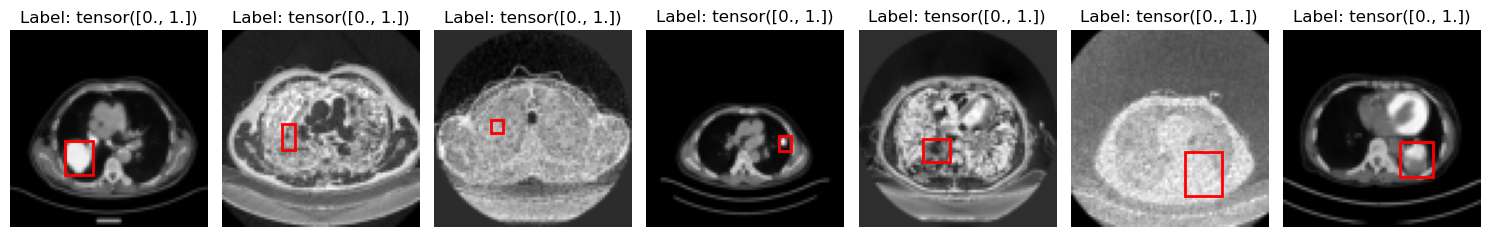

In [35]:
transform = transforms.Compose([
    transforms.Resize((image_size, image_size)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),        # Rotate by up to ±15 degrees
    transforms.RandomResizedCrop((224, 224),      # Random crop and resize to simulate zooming
                    scale=(0.8, 1.2),  # Scale for zoom in/out
                    ratio=(0.9, 1.1)),
    transforms.RandomAffine(degrees=0, shear=10), # Apply random shear with ±10 degrees
    transform
])



dataset = DICOMPETDataset(df=positive_samples, transform=transform, target_size=(image_size, image_size))
# dataset = DICOMCoarseDataset(root_dir=BASE_DIR, num_images_per_class=100, classes=["nodule", "non-nodule"], transform=transform, scenario=1)
dataset.visualize_images_with_bboxes(num_images=7)

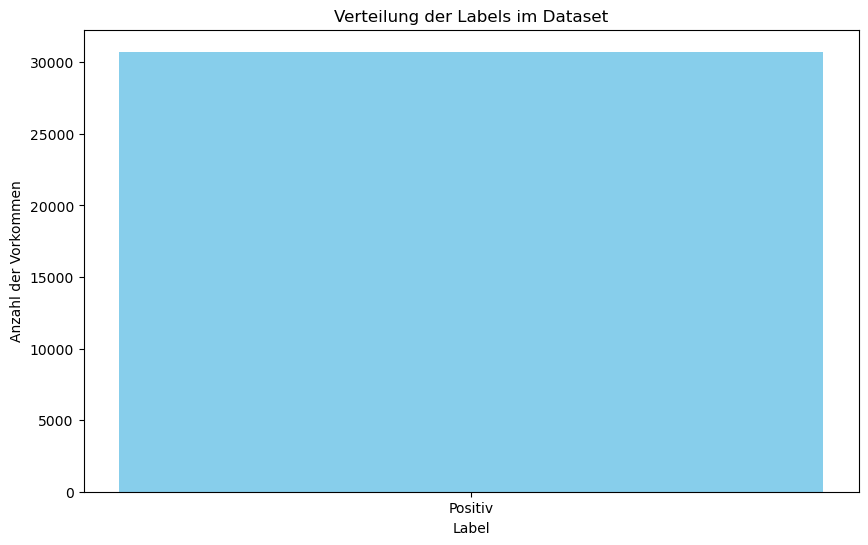

In [36]:
dataset.display_label_distribution()

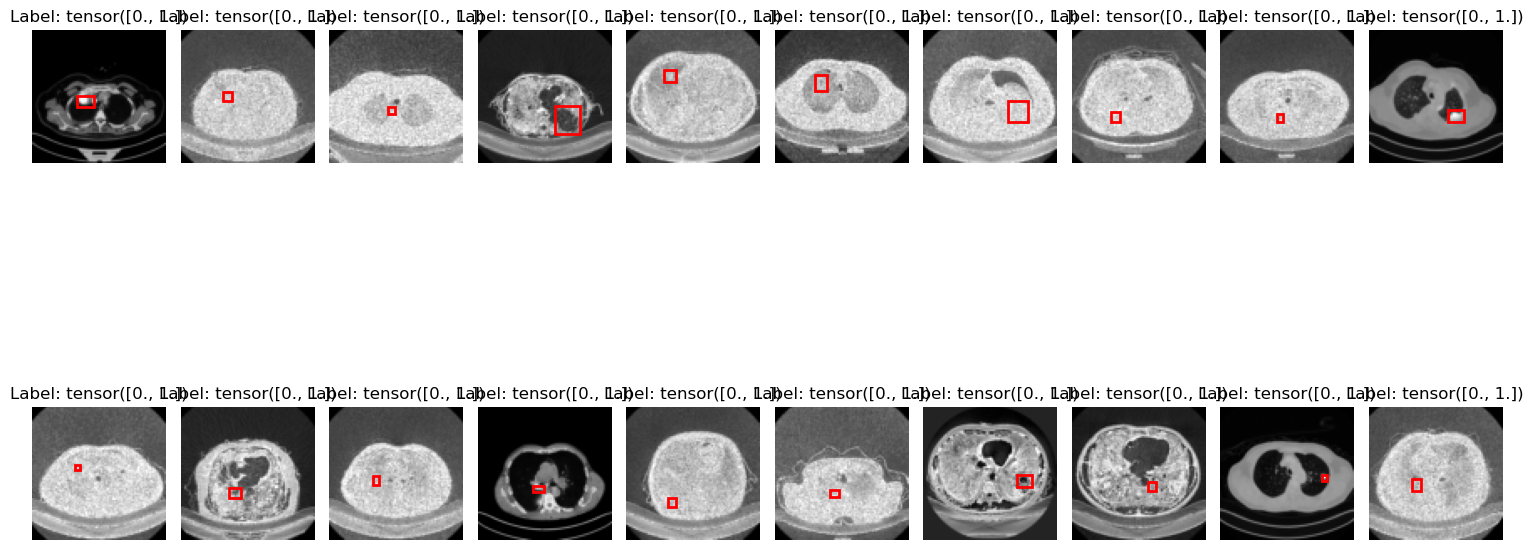

In [37]:
train_size = int(train_ratio * len(dataset))
test_size = len(dataset) - train_size

train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
# train_dataset.dataset.transform = train_transforms
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

visualize_dataloader_batch_with_bboxes(train_loader)

In [38]:
model = CapsuleNetwork(image_size=image_size)
model = model.to(device)
model

CapsuleNetwork(
  (conv_layer): ConvLayer(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
  )
  (primary_capsules): PrimaryCaps(
    (capsules): ModuleList(
      (0-7): 8 x Conv2d(256, 32, kernel_size=(9, 9), stride=(2, 2))
    )
  )
  (digit_capsules): DigitCaps()
  (decoder): Decoder(
    (linear_label_layers): Sequential(
      (0): Linear(in_features=32, out_features=512, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU(inplace=True)
      (4): Linear(in_features=1024, out_features=6400, bias=True)
      (5): Sigmoid()
    )
    (linear_boxes_layers): Sequential(
      (0): Linear(in_features=32, out_features=16, bias=True)
      (1): ReLU(inplace=True)
      (2): Linear(in_features=16, out_features=4, bias=True)
      (3): Sigmoid()
    )
  )
)

In [39]:
def get_num_correct(preds, labels):
    return torch.round(preds).argmax(dim=1).eq(labels).sum().item()

In [ ]:
def train(model):
    criterion = CapsuleLoss()
    # Defining the optimizer
    optimizer = optim.SGD(model.parameters(),lr = 0.001)
    num_of_epochs = 3
    epochs = []
    losses = []
    # Creating a directory for storing models
    # os.mkdir('models')
    for epoch in range(num_of_epochs):
        tot_loss = 0
        tot_correct = 0
        train_start = time.time()
        model.train()
        for batch, (images, labels, boxes) in enumerate(train_loader):
        	# Converting data from cpu to GPU if available to improve speed
            # images = images[:,np.newaxis, :]
            images, labels, boxes = images.to(device),labels.to(device),boxes.to(device)
            
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            [label_preds,reconstructions,y,box_preds]= model(images, boxes)
            # Compute loss (here CrossEntropyLoss)
            class_loss = criterion(label_preds, y, images, reconstructions)
            box_loss = F.mse_loss(box_preds, boxes)
            print('boxpreds',box_preds)
            print('boxes',boxes)
            # (box_loss + class_loss).backward()
            box_loss.backward()
            optimizer.step()
            print("Train batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')
            # print('Classification loss: ', class_loss)
            # print("-----")
            # print('BoundingBox loss: ', box_loss.cpu())

        model.eval()
        for batch, (images, labels, boxes) in enumerate(test_loader):
            # images = images[:,np.newaxis, :]
        	# Converting data from cpu to GPU if available to improve speed	
            images, labels, boxes = images.to(device),labels.to(device),boxes.to(device)
            # Sets the gradients of all optimized tensors to zero
            optimizer.zero_grad()
            with torch.no_grad():
                [label_preds,reconstructions,y,box_preds]= model(images, boxes)
                
                # Compute loss (here CrossEntropyLoss)
                class_loss = criterion(label_preds, y, images, reconstructions)
                box_loss = F.mse_loss(box_preds, boxes)
                # Compute loss (here CrossEntropyLoss)

            tot_loss += (class_loss.item() + box_loss.item())

            tot_correct += get_num_correct(torch.sum(label_preds, dim=-1), labels)
            print("Val batch:", batch+1, " epoch: ", epoch, " ",
                  (time.time()-train_start)/60, end='\r')
        epochs.append(epoch)
        losses.append(tot_loss)
        print("Epoch", epoch, "Accuracy", (tot_correct)/2.4, "loss:",
              tot_loss, " time: ", (time.time()-train_start)/60, " mins")
        # torch.save(model.state_dict(), "model_ep"+str(epoch+1)+".pth")

In [45]:
train(model)

boxpreds tensor([[0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779],
        [0.5598, 0.5575, 0.4660, 0.4779]], device='cuda:0',
       grad_fn=<SigmoidBackward0>)
boxes tensor([[47.8125, 37.6562, 60.6250, 50.9375],
        [51.8750, 38.5938, 62.8125, 49.8438],


KeyboardInterrupt: 

# KP

In [49]:
image_directory = "D:/Datasets/Lung-PET-CT-Dxr/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001"
# annotation_directory = 'dataset/annot'
annotation_directory = "C:/Users/chris/Documents/GitHub/Master/Object_Localization/dataset/dataset/annot"

In [28]:
def loadFileInformation(filename):
    # Erstelle ein leeres Dictionary, um die extrahierten DICOM-Informationen zu speichern.
    information = {}
    
    # Lese die DICOM-Datei mit dem angegebenen Dateinamen ein.
    # dicom.dcmread lädt den Inhalt der DICOM-Datei in ein Dataset-Objekt 'ds'.
    # Das Argument `force=True` ermöglicht das Einlesen, auch wenn die Datei 
    # kleinere Inkonsistenzen oder Fehler im Format hat.
    ds = dicom.dcmread(filename, force=True)
    
    # Greife auf die SOPInstanceUID in den DICOM-Metadaten zu.
    # Die SOPInstanceUID ist eine eindeutige Kennung für diese Bildinstanz.
    # Speichere diese UID im Dictionary unter dem Schlüssel 'dicom_num'.
    information['dicom_num'] = ds.SOPInstanceUID
    
    # Gib das Dictionary zurück, das die UID (SOPInstanceUID) enthält.
    return information


In [18]:
def getUID_path(path):
    dict = {}  # Initialisiere ein leeres Wörterbuch, um UIDs und Dateipfade zu speichern.
    list = os.listdir(path)  # Liste alle Unterverzeichnisse im angegebenen 'path' auf.

    for date in list:  # Schleife über jedes Unterverzeichnis (z. B. ein Datum).
        date_path = os.path.join(path, date)  # Erstelle den vollständigen Pfad für das Datum.
        series_list = os.listdir(date_path)  # Liste alle Serien in diesem Datumspfad auf.
        series_list.sort()  # Sortiere die Serienliste, um eine feste Reihenfolge zu haben.

        for series in series_list:  # Schleife über jede Serie im aktuellen Datumspfad.
            series_path = os.path.join(date_path, series)  # Vollständiger Pfad für die Serie.
            dicom_list = os.listdir(series_path)  # Liste alle DICOM-Dateien in der Serie auf.
            dicom_list.sort()  # Sortiere die DICOM-Dateien, um eine feste Reihenfolge zu haben.

            for dicom in dicom_list:  # Schleife über jede DICOM-Datei in der Serie.
                dicom_path = os.path.join(series_path, dicom)  # Vollständiger Pfad für die DICOM-Datei.
                info = loadFileInformation(dicom_path)  # Lese DICOM-Informationen (einschließlich UID) aus.
                dict[info['dicom_num']] = (dicom_path, dicom)  # Speichere UID als Schlüssel mit Pfad und Dateiname.

    return dict  # Gib das Wörterbuch mit allen gefundenen UIDs und zugehörigen Dateipfaden zurück.


In [29]:
import os

def getUID_path(path):
    dict = {}  # Initialisiere ein leeres Wörterbuch, um UIDs und Dateipfade zu speichern.

    # Verwende os.walk, um alle Verzeichnisse und Dateien ab 'path' rekursiv zu durchsuchen.
    for root, dirs, files in os.walk(path):
        # root: aktuelles Verzeichnis
        # dirs: Liste der Unterverzeichnisse im aktuellen Verzeichnis
        # files: Liste der Dateien im aktuellen Verzeichnis

        # Sortiere die Verzeichnisse und Dateien alphabetisch (optional, für feste Reihenfolge).
        dirs.sort()
        files.sort()

        # Schleife durch jede Datei im aktuellen Verzeichnis
        for dicom in files:
            dicom_path = os.path.join(root, dicom)  # Vollständiger Pfad für die DICOM-Datei
            info = loadFileInformation(dicom_path)  # Lese DICOM-Informationen (einschließlich UID) aus
            dict[info['dicom_num']] = (dicom_path, dicom)  # Speichere UID als Schlüssel mit Pfad und Dateiname

    return dict  # Gib das Wörterbuch mit allen gefundenen UIDs und zugehörigen Dateipfaden zurück.


In [30]:
bilder=getUID_path(image_directory)

In [31]:
bilder

{'1.3.6.1.4.1.14519.5.2.1.6655.2359.911257607240619696148712587012': ('D:/Datasets/Lung-PET-CT-Dxr/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001\\04-04-2007-NA-Chest-07990\\2.000000-5mm-40805\\1-01.dcm',
  '1-01.dcm'),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.184801338381895107635381026857': ('D:/Datasets/Lung-PET-CT-Dxr/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001\\04-04-2007-NA-Chest-07990\\2.000000-5mm-40805\\1-02.dcm',
  '1-02.dcm'),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.227252232966919521559290115017': ('D:/Datasets/Lung-PET-CT-Dxr/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001\\04-04-2007-NA-Chest-07990\\2.000000-5mm-40805\\1-03.dcm',
  '1-03.dcm'),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.305763411933569638615761005863': ('D:/Datasets/Lung-PET-CT-Dxr/manifest-1608669183333/Lung-PET-CT-Dx/Lung_Dx-A0001\\04-04-2007-NA-Chest-07990\\2.000000-5mm-40805\\1-04.dcm',
  '1-04.dcm'),
 '1.3.6.1.4.1.14519.5.2.1.6655.2359.892649213333065045357131733969': ('D:/Datasets/Lung-PET-CT-Dxr/m